In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
#from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_recall_fscore_support
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.linear_model import LinearRegression

from sklearn.naive_bayes import BernoulliNB

from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('master.csv')

In [4]:
df = df.replace(r'^\s+$', np.nan, regex=True)

In [4]:
df.isna().sum()

Store_Dept           0
Date                 0
Weekly_Sales         0
IsHoliday            0
Temperature          0
Fuel_Price           0
MarkDown1       270480
MarkDown2       278599
MarkDown3       276008
MarkDown4       278273
MarkDown5       270138
CPI                  0
Unemployment         0
Type                 0
Size                 0
dtype: int64

#### handling missing values: assign it to 0

In [5]:
df = df.fillna(0)

#### change data format

In [6]:
from datetime import datetime
df['Date'] = df['Date'].apply(lambda x: datetime.strptime(x, '%m/%d/%y'))

In [7]:
df["Year"] = pd.to_datetime(df["Date"], format="%Y-%m-%d").dt.year

In [8]:
df["Day"] = pd.to_datetime(df["Date"], format="%Y-%m-%d").dt.day

In [9]:
store_dept = df['Store_Dept'].str.split(pat='_', expand=True)

df['Store'] = store_dept[0]
df['Dept'] = store_dept[1]

#### data type convertion 

In [10]:
df["Store"] = df.Store.astype(float)
df["Dept"] = df.Dept.astype(float)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344667 entries, 0 to 344666
Data columns (total 19 columns):
Store_Dept      344667 non-null object
Date            344667 non-null datetime64[ns]
Weekly_Sales    344667 non-null float64
IsHoliday       344667 non-null bool
Temperature     344667 non-null float64
Fuel_Price      344667 non-null float64
MarkDown1       344667 non-null float64
MarkDown2       344667 non-null float64
MarkDown3       344667 non-null float64
MarkDown4       344667 non-null float64
MarkDown5       344667 non-null float64
CPI             344667 non-null float64
Unemployment    344667 non-null float64
Type            344667 non-null object
Size            344667 non-null int64
Year            344667 non-null int64
Day             344667 non-null int64
Store           344667 non-null float64
Dept            344667 non-null float64
dtypes: bool(1), datetime64[ns](1), float64(12), int64(3), object(2)
memory usage: 47.7+ MB


#### feature distributions 

In [12]:
df.groupby('Year')['Weekly_Sales'].mean()

Year
2010    16270.275737
2011    15954.070675
2012    15462.325272
Name: Weekly_Sales, dtype: float64

In [13]:
a=df.groupby('Year', as_index=False).agg({'Weekly_Sales':"mean"})
a.rename(columns = {"Weekly_Sales": 'Average_Sales'})

,Year,Average_Sales
0,2010,16270.275737
1,2011,15954.070675
2,2012,15462.325272


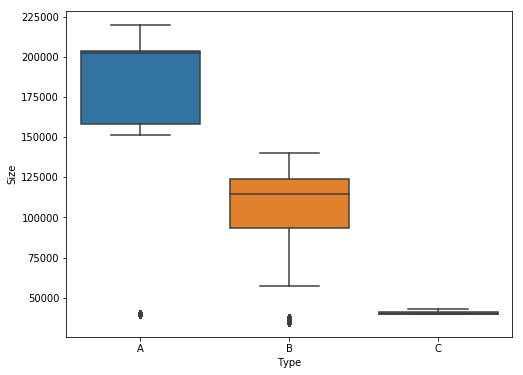

In [14]:
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='Type', y='Size', data=df)
#type A store is the largest store

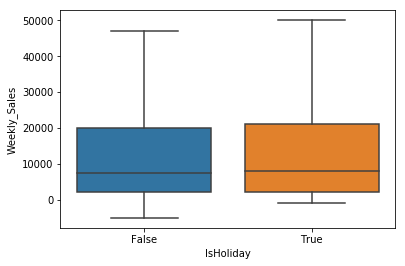

In [15]:
# setting showfliers = False will prevent outliers from plotting
sns.boxplot(x="IsHoliday", y="Weekly_Sales", data=df,
                showfliers=False)


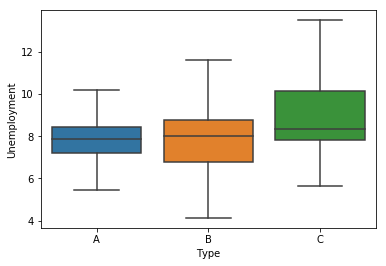

In [16]:
# determine unemployment vs weekly sales
sns.boxplot(x="Type", y="Unemployment", data=df,
                showfliers=False)

# from the plot, we can know people shop in Type A store has lowest unemployment rate, C is the highest

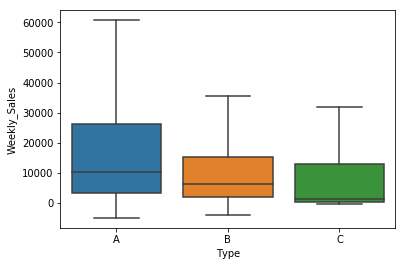

In [17]:
sns.boxplot(x="Type", y="Weekly_Sales", data=df,
               showfliers=False )

# from the plot, we can the median of Type A is the highest, sales is high might be because the unemployment rate in type A 
# is lowest and also type A has more sizes

In [18]:
df_A = df.loc[(df['Type']== 'A')]
print("Median of type A store weekly sales: ", df_A['Weekly_Sales'].median())

df_B = df.loc[df['Type']=='B']
print("Median of type B store weekly sales: ", df_B['Weekly_Sales'].median())

df_C = df.loc[df['Type']=='C']
print("Median of type C store weekly sales: ", round(df_C['Weekly_Sales'].median(),2))


Median of type A store weekly sales:  10157.81
Median of type B store weekly sales:  6187.555
Median of type C store weekly sales:  1183.53


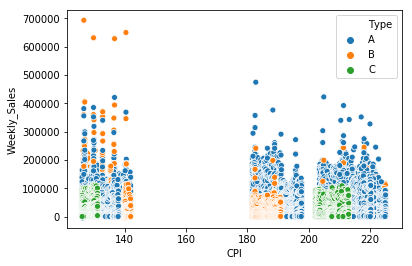

In [19]:
sns.scatterplot(x='CPI', y='Weekly_Sales', hue='Type', data=df)

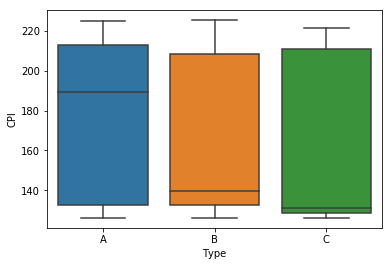

In [20]:
sns.boxplot(x="Type", y="CPI", data=df,
                showfliers=False)

#### build model-- Linear Regression

In [21]:
df_reg = df

#### dummy coding

In [22]:
df_reg =pd.get_dummies(df_reg, columns =['Type'])

#### plotting correlation map

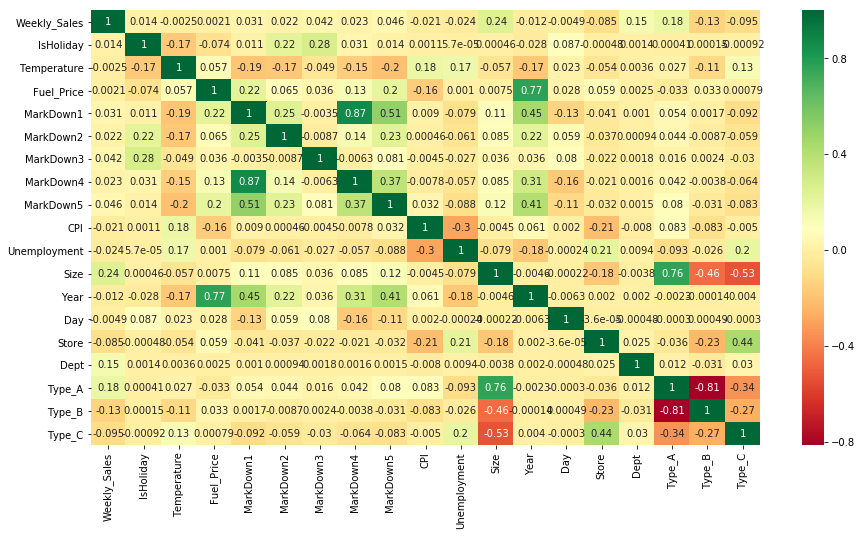

In [23]:
corrmat = df_reg.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(15,8))
#plot heat map
g=sns.heatmap(df_reg[top_corr_features].corr(),annot=True,cmap="RdYlGn")

#### select features for regression analysis

In [24]:
X_1 = df_reg[['MarkDown1','MarkDown3','MarkDown5','MarkDown2','MarkDown4','CPI','Unemployment','Temperature','Size',
              'Fuel_Price']]
y = df_reg[['Weekly_Sales']]


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_1, y, test_size=0.2, random_state=1)

In [26]:
clf = LinearRegression()

R2 = cross_val_score(clf, X_train,y_train, cv=10, scoring = 'r2')
mse =  cross_val_score(clf, X_train,y_train, cv=10, scoring = 'neg_mean_squared_error')
mae = cross_val_score(clf, X_train,y_train, cv=10, scoring = 'neg_mean_absolute_error')

In [27]:
print("R2 score : %.4f" % R2.mean())
print("Mean squared error: %.2f" % mse.mean())
print("MAE:" , mae.mean())

R2 score : 0.0612
Mean squared error: -492198255.38
MAE: -14574.347651911035


#### dummy coding for dept to improve R2-score

In [28]:
df_reg =pd.get_dummies(df_reg, columns =['Dept'])

In [29]:
X_2 = df_reg.drop(columns=['Year','Day','Store','Type_A','Type_B','Type_C','IsHoliday',
                          'Date','Store_Dept','Weekly_Sales'])

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_2, y, test_size=0.2, random_state=1)

R2 = cross_val_score(clf, X_train,y_train, cv=10, scoring = 'r2')
mse =  cross_val_score(clf, X_train,y_train, cv=10, scoring = 'neg_mean_squared_error')
mae = cross_val_score(clf, X_train,y_train, cv=10, scoring = 'neg_mean_absolute_error')

print("R2 score : %.4f" % R2.mean())
print("Mean squared error: %.2f" % mse.mean())
print("Mae:" , mae.mean())

R2 score : 0.6161
Mean squared error: -201398999.44
Mae: -8570.37426680257


#### perform Random Forest for X_1

In [31]:
X_1 = df_reg[['MarkDown1','MarkDown3','MarkDown5','MarkDown2','MarkDown4','CPI','Unemployment','Temperature','Size',
              'Fuel_Price']]

X_train, X_test, y_train, y_test = train_test_split(X_1, y, test_size=0.2, random_state=1)

In [33]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators = 100 ,max_depth=15,n_jobs=5)        
rfr.fit(X_train,y_train)
y_pred=rfr.predict(X_test)

R2 = cross_val_score(rfr, X_train,y_train, cv=10, scoring = 'r2')

In [35]:
mse =  cross_val_score(rfr, X_train,y_train, cv=10, scoring = 'neg_mean_squared_error')
mae = cross_val_score(rfr, X_train,y_train, cv=10, scoring = 'neg_mean_absolute_error')

C:\Users\wen\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\wen\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\wen\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\wen\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed

In [36]:
print("R2 score : %.4f" % R2.mean())
print("Mean squared error: %.2f" % mse.mean())
print("MAE:" , mae.mean())

R2 score : 0.0817
Mean squared error: -481470982.52
MAE: -14391.779967652783


#### perform random forest for x_2

In [37]:
X_2 = df_reg.drop(columns=['Year','Day','Store','Type_A','Type_B','Type_C','IsHoliday',
                          'Date','Store_Dept','Weekly_Sales'])

X_train, X_test, y_train, y_test = train_test_split(X_2, y, test_size=0.2, random_state=1)

In [38]:
rfr.fit(X_train,y_train)
y_pred=rfr.predict(X_test)

R2 = cross_val_score(rfr, X_train,y_train, cv=10, scoring = 'r2')
mse =  cross_val_score(rfr, X_train,y_train, cv=10, scoring = 'neg_mean_squared_error')
mae = cross_val_score(rfr, X_train,y_train, cv=10, scoring = 'neg_mean_absolute_error')

C:\Users\wen\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.
C:\Users\wen\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\wen\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\wen\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array 

C:\Users\wen\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\wen\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


In [39]:
print("R2 score : %.4f" % R2.mean())
print("Mean squared error: %.2f" % mse.mean())
print("MAE:" , mae.mean())

R2 score : 0.7762
Mean squared error: -117420892.18
MAE: -6941.553567091636


#### Perform final optimal features on test set

In [45]:
test = pd.read_csv('test.csv')

In [46]:
test = test.fillna(0)

In [47]:
from datetime import datetime
test['Date'] = test['Date'].apply(lambda x: datetime.strptime(x, '%m/%d/%y'))

In [48]:
store_dept = test['Store_Dept'].str.split(pat='_', expand=True)

test['Store'] = store_dept[0]
test['Dept'] = store_dept[1]

test["Store"] = test.Store.astype(float)
test["Dept"] = test.Dept.astype(float)

In [49]:
test["Year"] = pd.to_datetime(test["Date"], format="%Y-%m-%d").dt.year
test["Day"] = pd.to_datetime(test["Date"], format="%Y-%m-%d").dt.day

In [50]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76903 entries, 0 to 76902
Data columns (total 19 columns):
Store_Dept      76903 non-null object
Weekly_Sales    76903 non-null float64
Date            76903 non-null datetime64[ns]
IsHoliday       76903 non-null bool
Temperature     76903 non-null float64
Fuel_Price      76903 non-null float64
MarkDown1       76903 non-null float64
MarkDown2       76903 non-null float64
MarkDown3       76903 non-null float64
MarkDown4       76903 non-null float64
MarkDown5       76903 non-null float64
CPI             76903 non-null float64
Unemployment    76903 non-null float64
Type            76903 non-null object
Size            76903 non-null int64
Store           76903 non-null float64
Dept            76903 non-null float64
Year            76903 non-null int64
Day             76903 non-null int64
dtypes: bool(1), datetime64[ns](1), float64(12), int64(3), object(2)
memory usage: 10.6+ MB


In [51]:
reg_test = test

In [52]:
reg_test =pd.get_dummies(reg_test, columns =['Dept'])

In [53]:
reg_test =pd.get_dummies(reg_test, columns =['Type'])

#### building model on testset

In [54]:
final_data = reg_test.drop(columns=['Year','Day','Store','Type_A','Type_B','Type_C','IsHoliday',
                          'Date','Store_Dept','Weekly_Sales'])
y = reg_test[['Weekly_Sales']]

In [55]:
X_train, X_test, y_train, y_test = train_test_split(final_data, y, test_size=0.2, random_state=1)

In [56]:
R2 = cross_val_score(rfr, X_train,y_train, cv=10, scoring = 'r2')
mse =  cross_val_score(rfr, X_train,y_train, cv=10, scoring = 'neg_mean_squared_error')
mae = cross_val_score(rfr, X_train,y_train, cv=10, scoring = 'neg_mean_absolute_error')

print("R2 score : %.4f" % R2.mean())
print("Mean squared error: %.2f" % mse.mean())
print("MAE:" , mae.mean())

C:\Users\wen\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\wen\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\wen\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\wen\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed

C:\Users\wen\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


R2 score : 0.8152
Mean squared error: -88532781.44
MAE: -6582.685898418703


#### perform knn Classification

In [57]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)

In [65]:
#classification
df_c = df

In [66]:
df_c.isna().sum()

Store_Dept      0
Date            0
Weekly_Sales    0
IsHoliday       0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Type            0
Size            0
Year            0
Day             0
Store           0
Dept            0
dtype: int64

In [67]:
df_c=pd.get_dummies(df_c, columns =['IsHoliday'])

In [68]:
X =  df_c.drop(columns=['Type','Date',"Store_Dept"])

In [69]:
y = df_c[['Type']]

In [70]:
print(y.head(5))

  Type
0    A
1    A
2    A
3    A
4    A


#### feature selections

C:\Users\wen\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\wen\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


[6.32023596e-03 9.17392321e-03 1.01443589e-02 3.47136607e-03
 2.31435140e-03 2.19253023e-03 2.50018677e-03 5.79988978e-03
 6.79441762e-02 5.22276626e-02 5.75548313e-01 5.22879265e-03
 7.85568838e-04 2.53745420e-01 2.26660183e-03 1.27638133e-04
 2.08984222e-04]


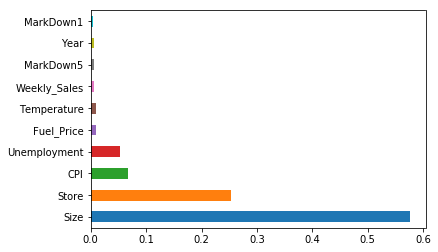

In [71]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [79]:
X_1 = df_c[["Temperature",'Fuel_Price','CPI','Unemployment','Store','Size','Weekly_Sales','Year','MarkDown5','MarkDown1']]

In [80]:
X_train,X_test,y_train,y_test=train_test_split(X_1, y, test_size=0.2, random_state=0)

In [81]:
knn.fit(X_train, y_train)

#from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
#y_pred = cross_val_predict(knn, X_train, y_train, cv=10)
y_pred= knn.predict(X_test)

C:\Users\wen\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """Entry point for launching an IPython kernel.


In [82]:
f1_score = cross_val_score(knn, X_train,y_train, cv=10, scoring ='f1_macro' )
recall_score = cross_val_score(knn, X_train, y_train, scoring = 'recall_weighted', cv=10)
precision_score = cross_val_score(knn, X_train, y_train, scoring = 'precision_macro', cv=10)

C:\Users\wen\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\wen\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\wen\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\wen\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was pas

C:\Users\wen\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


In [ ]:
print("Precision: %0.2f" % precision_score.mean())
print("Recall:  %0.2f" % recall_score.mean())
print("F1-score:  %0.2f" % f1_score.mean())
#compute recall and f1-score

In [ ]:
print(confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

### perform knn on test data

In [90]:
test_c = test

In [93]:
X = test_c[["Temperature",'Fuel_Price','CPI','Unemployment','Store','Size','Weekly_Sales','Year','MarkDown5','MarkDown1']]
y = test_c[['Type']]

In [94]:
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.2, random_state=0)

knn.fit(X_train, y_train)

C:\Users\wen\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [95]:
#from sklearn.metrics import confusion_matrix
#y_pred = cross_val_predict(knn, X_train, y_train, cv=10)
y_pred= knn.predict(X_test)

In [96]:
f1_score = cross_val_score(knn, X_train,y_train, cv=10, scoring ='f1_macro' )
precision_score = cross_val_score(knn, X_train,y_train, cv=10, scoring ='precision_macro' )
recall_score = cross_val_score(knn, X_train,y_train, cv=10, scoring ='recall_weighted' )

C:\Users\wen\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\wen\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\wen\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\wen\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was pas

C:\Users\wen\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


In [97]:
print("Precision: %0.2f" %precision_score.mean())
print("Recall:  %0.2f" %recall_score.mean())
print("F1-score:  %0.2f" %f1_score.mean())
#compute recall and f1-score 

#from sklearn.metrics import confusion_matrix
print (confusion_matrix(y_test, y_pred))
print (metrics.classification_report(y_test, y_pred))

Precision: 0.96
Recall:  0.98
F1-score:  0.96
[[7639    0  199]
 [   1 5962    3]
 [ 115    0 1462]]
              precision    recall  f1-score   support

           A       0.99      0.97      0.98      7838
           B       1.00      1.00      1.00      5966
           C       0.88      0.93      0.90      1577

   micro avg       0.98      0.98      0.98     15381
   macro avg       0.95      0.97      0.96     15381
weighted avg       0.98      0.98      0.98     15381



# Clustering

In [27]:
from sklearn.cluster import KMeans

In [50]:
df_cluster = df

In [51]:
df_cluster = pd.get_dummies(df_cluster, columns=['Type','IsHoliday'])

In [52]:
X = df_cluster.drop(columns = ['Date'])

In [53]:
#standardize the data to normal distribution
from sklearn import preprocessing
dataset1_standardized = preprocessing.scale(X)
dataset1_standardized = pd.DataFrame(dataset1_standardized)

C:\Users\wen\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8, int64, float64, object were all converted to float64 by the scale function.
  This is separate from the ipykernel package so we can avoid doing imports until


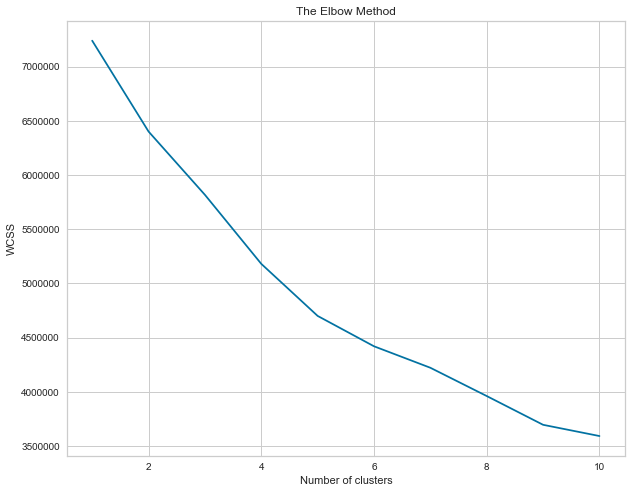

In [55]:

plt.figure(figsize=(10, 8))
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(dataset1_standardized)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [48]:
range_n_clusters = list(range(2,15))

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(X)
    centers = clusterer.cluster_centers_

    score = silhouette_score(X, preds, metric='euclidean')
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", score)

    #print ("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

For n_clusters = 2 The average silhouette_score is : 0.5412933229561399
For n_clusters = 3 The average silhouette_score is : 0.5877642756829841
For n_clusters = 4 The average silhouette_score is : 0.5946865721371581
For n_clusters = 5 The average silhouette_score is : 0.5413002491501472
For n_clusters = 6 The average silhouette_score is : 0.556242743164916
For n_clusters = 7 The average silhouette_score is : 0.5434694955797277
For n_clusters = 8 The average silhouette_score is : 0.5202013133083229
For n_clusters = 9 The average silhouette_score is : 0.5212504093525653
For n_clusters = 10 The average silhouette_score is : 0.5171929029239632
For n_clusters = 11 The average silhouette_score is : 0.4884466958999289
For n_clusters = 12 The average silhouette_score is : 0.487974100799591
For n_clusters = 13 The average silhouette_score is : 0.4701751023425832
For n_clusters = 14 The average silhouette_score is : 0.5055481635552194


In [106]:
kmeans = KMeans(n_clusters=5)
# fit kmeans object to data
kmeans.fit(X)
# print location of clusters learned by kmeans object
print(kmeans.cluster_centers_)
# save new clusters for chart
y_km = kmeans.fit_predict(X)

[[ 1.64571728e+03  8.15263282e+04  8.26298780e-02  5.75162896e+01
   3.26945685e+00  2.19307571e+03  1.51727512e+03  1.14357110e+03
   1.06672878e+03  1.55606454e+03  1.74296288e+02  7.88252983e+00
   1.95296720e+05  2.01073494e+03  1.53927934e+01  1.86030100e+01
   6.05520718e+01  9.57551493e-01  4.24485071e-02 -3.46805917e-14]
 [ 2.22436930e+03  8.15665702e+03  7.72891782e-02  6.10153343e+01
   3.23154041e+00  4.77521091e+02  1.95893245e+02  1.36978461e+02
   1.36163734e+02  4.15312964e+02  1.83706940e+02  8.33715932e+00
   4.44626527e+04  2.01074485e+03  1.56031340e+01  2.57569699e+01
   4.50536384e+01  1.37277777e-01  4.03547613e-01  4.59174610e-01]
 [ 1.95851673e+03  1.31234133e+04  7.71003097e-02  5.43519830e+01
   3.35720326e+00  1.77161122e+03  1.18872185e+03  6.50677592e+02
   8.53102367e+02  1.02491514e+03  1.50286085e+02  8.32198260e+00
   1.14955952e+05  2.01073827e+03  1.56043417e+01  2.17146073e+01
   4.33853007e+01 -7.83928478e-13  1.00000000e+00  1.04402598e-13]
 [ 1.90